**This is the implementaion of Non-Driving Activity using Two-Stream ConvNets. For the optical flow, this research is using flowNet, please follow the steps.
Notice: Remember to change the notbook instance into GPU mode.<br>
These code are written by Tingyu Yang. All right reserved.**

In [37]:
!nvidia-smi #check the GPU version

Wed Jul 17 14:50:47 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    16W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import files   # upload the code zip file
uploaded = files.upload()

Saving flowNet_Two_stream_CNN_1080_code.zip to flowNet_Two_stream_CNN_1080_code.zip


In [3]:
%%sh
unzip flowNet_Two_stream_CNN_1080_code.zip # unzip the zip file

Archive:  flowNet_Two_stream_CNN_1080_code.zip
   creating: flowNet_Two_stream_CNN_1080_code/
  inflating: flowNet_Two_stream_CNN_1080_code/predict_pickle_reader_for_loop.py  
   creating: __MACOSX/
   creating: __MACOSX/flowNet_Two_stream_CNN_1080_code/
  inflating: __MACOSX/flowNet_Two_stream_CNN_1080_code/._predict_pickle_reader_for_loop.py  
  inflating: flowNet_Two_stream_CNN_1080_code/.DS_Store  
  inflating: __MACOSX/flowNet_Two_stream_CNN_1080_code/._.DS_Store  
   creating: flowNet_Two_stream_CNN_1080_code/record/
  inflating: flowNet_Two_stream_CNN_1080_code/record/.DS_Store  
   creating: __MACOSX/flowNet_Two_stream_CNN_1080_code/record/
  inflating: __MACOSX/flowNet_Two_stream_CNN_1080_code/record/._.DS_Store  
   creating: flowNet_Two_stream_CNN_1080_code/record/motion/
  inflating: flowNet_Two_stream_CNN_1080_code/record/motion/.DS_Store  
   creating: __MACOSX/flowNet_Two_stream_CNN_1080_code/record/motion/
  inflating: __MACOSX/flowNet_Two_stream_CNN_1080_code/record/mo

In [4]:
cd flowNet_Two_stream_CNN_1080_code/

/content/flowNet_Two_stream_CNN_1080_code


# **Load Data Using curl**

**Load the cropped video using station307.com, which allow the user to send files using CURL. This could save a lot of time when transfering data when training on cloud.
The flowNet data should contains all frames for each video.
The RGB data should contain video.
Notice: the url for curl will be differnt, ex: https://get.station307.com/y5i6VuL9mG5/cropped_flowNet_1080.zip, you should change the url to your own url.**

### **Load the flowNet zip file**

In [5]:
!curl https://get.station307.com/9wH0FKOeLOg/cropped_flowNet_1080.zip -o cropped_flowNet_1080.zip 
#get the zip file of flowNet data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3535M  100 3535M    0     0  11.4M      0  0:05:09  0:05:09 --:--:-- 11.9M


In [6]:
%%sh
unzip cropped_flowNet_1080.zip #unzip the flowNet data

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### **Load the RGB video zip file**

In [7]:
!curl https://get.station307.com/gNsE3tV47Fd/cropped_1080.zip -o cropped.zip 
#get the zip file of RGB video data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2947M  100 2947M    0     0  11.7M      0  0:04:10  0:04:10 --:--:-- 11.9M


In [8]:
%%sh
unzip cropped.zip #unzip the RGB video data

Archive:  cropped.zip
   creating: cropped_1080/
  inflating: cropped_1080/mobileEmail_g01.mp4  
   creating: __MACOSX/cropped_1080/
  inflating: __MACOSX/cropped_1080/._mobileEmail_g01.mp4  
  inflating: cropped_1080/mobileBrowse_g01.mp4  
  inflating: __MACOSX/cropped_1080/._mobileBrowse_g01.mp4  
  inflating: cropped_1080/tabletClip_g09.mp4  
  inflating: __MACOSX/cropped_1080/._tabletClip_g09.mp4  
  inflating: cropped_1080/mobileRead_g09.mp4  
  inflating: __MACOSX/cropped_1080/._mobileRead_g09.mp4  
  inflating: cropped_1080/mobileBrowse_g02.mp4  
  inflating: __MACOSX/cropped_1080/._mobileBrowse_g02.mp4  
  inflating: cropped_1080/mobileEmail_g02.mp4  
  inflating: __MACOSX/cropped_1080/._mobileEmail_g02.mp4  
  inflating: cropped_1080/mobileEmail_g03.mp4  
  inflating: __MACOSX/cropped_1080/._mobileEmail_g03.mp4  
  inflating: cropped_1080/mobileBrowse_g03.mp4  
  inflating: __MACOSX/cropped_1080/._mobileBrowse_g03.mp4  
  inflating: cropped_1080/mobileRead_g08.mp4  
  inflatin

In [0]:
!mkdir cropped/ # make a dir to store frames extract from video
!mv cropped_1080/* cropped/

In [10]:
# extract frame from video 
import cv2
import os

jpeg_des_path = 'cropped_jpeg_1080'
if not os.path.isdir(jpeg_des_path):
  os.mkdir(jpeg_des_path)

for file in os.listdir('cropped'):
  if '.' in file:
    if file.split('.')[1] == 'mp4':
      current_video_name = file.split('.')[0]
      print(file)
      if not os.path.isdir(os.path.join(jpeg_des_path, current_video_name)):
        os.mkdir(os.path.join(jpeg_des_path, current_video_name))
      
      cap = cv2.VideoCapture(os.path.join('cropped', file))
      
      images = []
      while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
          break
        images.append(frame)
      
      for i, image in enumerate(images):
        save_root = os.path.join(jpeg_des_path, current_video_name)
        cv2.imwrite(os.path.join(save_root, 'frame_{:06d}.jpg'.format(i + 1)), image)
      cap.release()


mobileGame_g04.mp4
mobileEmail_g08.mp4
mobileRead_g06.mp4
mobileRead_g05.mp4
mobileCall_g05.mp4
mobileEmail_g05.mp4
mobileEmail_g01.mp4
mobileBrowse_g05.mp4
tabletEmail_g03.mp4
mobileClip_g06.mp4
mobileRead_g09.mp4
mobileCall_g10.mp4
mobileCall_g03.mp4
tabletGame_g07.mp4
tabletGame_g03.mp4
tabletRead_g09.mp4
tabletRead_g02.mp4
tabletGame_g04.mp4
mobileClip_g04.mp4
tabletBrowse_g07.mp4
mobileRead_g08.mp4
tabletBrowse_g03.mp4
mobileRead_g07.mp4
tabletEmail_g07.mp4
tabletBrowse_g02.mp4
mobileCall_g06.mp4
mobileGame_g09.mp4
mobileClip_g07.mp4
mobileRead_g02.mp4
mobileClip_g09.mp4
tabletGame_g01.mp4
mobileClip_g08.mp4
mobileBrowse_g06.mp4
tabletEmail_g10.mp4
mobileGame_g03.mp4
tabletClip_g08.mp4
mobileGame_g02.mp4
tabletEmail_g05.mp4
mobileCall_g02.mp4
tabletEmail_g01.mp4
tabletEmail_g04.mp4
mobileBrowse_g08.mp4
tabletBrowse_g01.mp4
tabletBrowse_g05.mp4
mobileGame_g05.mp4
tabletGame_g05.mp4
tabletClip_g09.mp4
tabletClip_g10.mp4
tabletEmail_g06.mp4
mobileCall_g08.mp4
mobileBrowse_g02.mp4
mob

### To safe jpeg, but it would take lots of time (Not recommenced)

In [0]:
!zip -r cropped_jpeg_1080.zip cropped_jpeg_1080/

In [0]:
!curl -T cropped_jpeg_1080.zip -Lv station307.com 2>&1 | grep located-at

< com.station307.located-at: https://get.station307.com/72bmtSh8nN8/cropped_jpeg_1080.zip
^C


### Split each video frame into 4 second short frame

In [11]:
!python split_g2c.py --jpg-path cropped_jpeg_1080/ --opt-path cropped_flowNet_1080/ --fps 24 --sec 4
#less sec more validate time in motion stream, beacause files beacam more

Namespace(fps=24, jpg_path='cropped_jpeg_1080/', opt_path='cropped_flowNet_1080/', sec=4)
jpg splitting...
mobileGame_g09 1700 17 18
mobileRead_g10 1630 16 17
tabletEmail_g04 1653 17 18
mobileCall_g04 1164 12 13
mobileGame_g10 2146 22 23
mobileBrowse_g04 1747 18 19
mobileRead_g03 1434 14 15
mobileRead_g06 1810 18 19
tabletEmail_g06 1548 16 17
tabletRead_g10 1639 17 18
mobileClip_g06 1394 14 15
mobileClip_g07 1489 15 16
mobileCall_g02 1398 14 15
tabletBrowse_g09 1775 18 19
tabletGame_g07 2430 25 26
tabletRead_g08 1604 16 17
tabletRead_g06 1605 16 17
tabletClip_g10 1705 17 18
mobileGame_g06 1873 19 20
mobileGame_g07 1436 14 15
mobileBrowse_g02 1364 14 15
mobileRead_g05 1522 15 16
tabletEmail_g08 1574 16 17
mobileGame_g01 1270 13 14
tabletEmail_g02 1603 16 17
tabletRead_g09 1582 16 17
mobileGame_g04 1713 17 18
mobileEmail_g04 1760 18 19
tabletGame_g06 616 6 7
mobileEmail_g03 1750 18 19
mobileEmail_g06 1831 19 20
tabletGame_g05 1866 19 20
mobileGame_g08 1677 17 18
tabletRead_g05 1565 16 17

#Make demo video rgb and opt


> Enter the correct folder of rgb and optical flow directory with the name of  folder for demo




In [0]:
!python make_opt_rgb_video.py --jpg-path jpeg_1080/ --opt-path flowNet_1080/ --class-name tabletClip_g09_c07

Namespace(class_name='tabletClip_g09_c07', jpg_path='jpeg_1080/', opt_path='flowNet_1080/')
96 96
600 600
Traceback (most recent call last):
  File "make_opt_rgb_video.py", line 63, in <module>
    vis = np.concatenate((opt_image[i], rbg_image[i]), axis=1)
ValueError: all the input array dimensions except for the concatenation axis must match exactly


make video with prediction percentage by participants

In [60]:
!python make_opt_rgb_video_with_predict_level.py --jpg-path jpeg_1080/ --opt-path flowNet_1080/ \
--participant g03 

Namespace(classes='NDA_list/classInd.txt', jpg_path='jpeg_1080/', optPred='record/motion/evel_motion_video_preds.pickle', opt_path='flowNet_1080/', participant='g03', rgbPred='record/spatial/evel_spatial_video_preds.pickle')
['mobileBrowse', 'mobileCall', 'mobileClip', 'mobileEmail', 'mobileGame', 'mobileRead', 'tabletBrowse', 'tabletClip', 'tabletEmail', 'tabletGame', 'tabletRead']
['mobileBrowse_g03_c03', 'mobileBrowse_g03_c08', 'mobileBrowse_g03_c09', 'mobileBrowse_g03_c11', 'mobileCall_g03_c06', 'mobileCall_g03_c08', 'mobileCall_g03_c10', 'mobileCall_g03_c11', 'mobileClip_g03_c03', 'mobileClip_g03_c07', 'mobileClip_g03_c11', 'mobileClip_g03_c14', 'mobileEmail_g03_c02', 'mobileEmail_g03_c08', 'mobileEmail_g03_c10', 'mobileEmail_g03_c16', 'mobileEmail_g03_c18', 'mobileGame_g03_c05', 'mobileGame_g03_c12', 'mobileGame_g03_c15', 'mobileGame_g03_c16', 'mobileRead_g03_c02', 'mobileRead_g03_c07', 'mobileRead_g03_c08', 'mobileRead_g03_c09', 'tabletBrowse_g03_c08', 'tabletBrowse_g03_c12', 't

In [54]:
!curl -T demo_g03.mp4 -Lv station307.com 2>&1 | grep located-at

< com.station307.located-at: https://get.station307.com/rJe4frgQp3b/demo_g03.mp4
^C


# **Training Process**

In [12]:
!python get_class.py # get category file

Namespace(jpg_path='jpeg_1080')
1 mobileBrowse

2 mobileCall

3 mobileClip

4 mobileEmail

5 mobileGame

6 mobileRead

7 tabletBrowse

8 tabletClip

9 tabletEmail

10 tabletGame

11 tabletRead



### Get train and test list for training and testing, default is 70%/20%/10% train/test/inference. This is seperated by each participant, meaning data for each participant is seperated by the ratio

In [13]:
!python get_list_70_20_10_by_people.py --train 64 --test 16 --inference 20

Namespace(inference=20, jpg_path='jpeg_1080', test=16, train=64)


### Get train and test list for training and testing, default is 70%/20%/10% train/test/inference. This is seperated all randomisation, meaning all the data will be randomly chosed, no matter the participants.

In [0]:
!python get_list_70_20_10.py --train 64 --test 16 --inference 20

Namespace(inference=20, jpg_path='jpeg_1080', test=16, train=64)
['mobileGame_g05_c16.mp4', 'mobileBrowse_g05_c12.mp4', 'tabletRead_g06_c02.mp4', 'mobileGame_g04_c17.mp4', 'mobileClip_g05_c02.mp4', 'mobileRead_g01_c05.mp4', 'tabletGame_g04_c19.mp4', 'tabletGame_g05_c04.mp4', 'tabletRead_g02_c14.mp4', 'mobileClip_g09_c06.mp4', 'tabletGame_g06_c03.mp4', 'tabletEmail_g08_c07.mp4', 'mobileEmail_g10_c09.mp4', 'mobileBrowse_g01_c10.mp4', 'mobileCall_g06_c04.mp4', 'tabletGame_g08_c10.mp4', 'mobileClip_g02_c13.mp4', 'tabletClip_g05_c11.mp4', 'tabletGame_g09_c10.mp4', 'mobileClip_g05_c11.mp4', 'tabletGame_g04_c06.mp4', 'mobileClip_g01_c03.mp4', 'mobileCall_g09_c12.mp4', 'mobileGame_g09_c14.mp4', 'tabletRead_g04_c05.mp4', 'mobileGame_g04_c02.mp4', 'tabletBrowse_g02_c05.mp4', 'mobileRead_g05_c07.mp4', 'mobileClip_g09_c05.mp4', 'tabletBrowse_g08_c03.mp4', 'tabletClip_g09_c03.mp4', 'mobileGame_g03_c10.mp4', 'tabletEmail_g01_c11.mp4', 'mobileEmail_g07_c16.mp4', 'mobileRead_g01_c14.mp4', 'tabletRead_

### Get the frame count

In [14]:
!python get_frame_count_pickle.py

Namespace(jpg_path='jpeg_1080')


In [0]:
!python dataloader/dic/pickle_reader.py

{'mobileBrowse_g06_c12': 96, 'tabletEmail_g07_c08': 96, 'tabletBrowse_g09_c10': 96, 'tabletEmail_g01_c11': 96, 'mobileGame_g05_c18': 96, 'mobileClip_g10_c02': 96, 'tabletGame_g04_c13': 96, 'mobileCall_g05_c09': 96, 'mobileBrowse_g06_c18': 96, 'mobileRead_g02_c08': 96, 'tabletGame_g09_c08': 96, 'mobileEmail_g04_c03': 96, 'mobileCall_g02_c04': 96, 'mobileBrowse_g06_c09': 96, 'mobileEmail_g10_c10': 96, 'mobileBrowse_g01_c10': 96, 'mobileClip_g04_c12': 96, 'tabletGame_g09_c15': 96, 'tabletEmail_g09_c04': 96, 'tabletBrowse_g06_c14': 96, 'tabletBrowse_g05_c04': 96, 'tabletEmail_g10_c07': 96, 'mobileRead_g06_c14': 96, 'mobileCall_g02_c12': 96, 'mobileBrowse_g10_c13': 96, 'tabletGame_g06_c06': 96, 'mobileGame_g06_c16': 96, 'mobileBrowse_g07_c17': 96, 'mobileEmail_g09_c07': 96, 'tabletGame_g02_c16': 96, 'tabletBrowse_g01_c15': 96, 'tabletGame_g01_c17': 96, 'mobileBrowse_g06_c08': 96, 'tabletRead_g10_c07': 96, 'mobileClip_g04_c04': 96, 'mobileCall_g05_c04': 96, 'mobileGame_g08_c05': 96, 'tabletC

### Start training spatical and motion stream.

1.   lr = learning rate
2.   epochs = how many epoch to train?
3.   jpeg = path to RGB frame folder
4.   NDAlist = folder for train and test list
5.   batch-size = batch size for training
6.   net-size = how many layers for ResNet: 18, 34, 50 or 101?
7.   numClass = how many categories for classification?

Two model will be stored in the record folder, checkpoint model and the best model. The selection method of best model is best validate accuracy with best training loss function.




In [15]:
!python spatial_cnn.py  --lr 0.005 --epochs 20 --jpeg jpeg_1080/ --NDAlist NDA_list/ \
--batch-size 32 --net-size 50 --numClass 11

Namespace(NDAlist='NDA_list/', batch_size=32, epochs=20, evaluate=False, imgCropSize=224, jpeg='jpeg_1080/', lr=0.005, net_size=50, numClass=11, resume='', start_epoch=0)
==> (Training video, Validation video):( 1045 274 )
==> Generate frame numbers of each training video
==> sampling testing frames
==> Training data : 1045 frames
torch.Size([3, 224, 224])
==> Validation data : 5206 frames
torch.Size([3, 224, 224])
==> Build model and setup loss and optimizer
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100% 102502400/102502400 [00:01<00:00, 66066489.40it/s]
==> Epoch:[0/20][training stage]
100% 33/33 [00:46<00:00,  1.52s/it]
Time [1.419] Data [0.331] 
Loss [3.80684] Prec@1 [34.8325] Prec@3 [57.799]
LR 0.005

==> Epoch:[0/20][validation stage]
100% 163/163 [00:58<00:00,  2.13it/s]
Time [0.359] 
Loss [50.72686] Prec@1 [26.642] Prec@3 [55.109] 

best model updated!!!!!!!
==> Epoch:[1/20][training stage]
1

In [16]:
!python motion_cnn.py  --lr 0.005 --epochs 6 --opt flowNet_1080/ --NDAlist NDA_list/ \
--batch-size 16 --net-size 50 --numClass 11

Namespace(NDAlist='NDA_list/', batch_size=16, epochs=6, evaluate=False, lr=0.005, net_size=50, numClass=11, opt='flowNet_1080/', resume='', start_epoch=0)
==> (Training video, Validation video):( 1045 274 )
==> Training data : 1045  videos torch.Size([30, 224, 224])
==> Validation data : 5206  frames torch.Size([30, 224, 224])
==> Build model and setup loss and optimizer
==> Epoch:[0/6][training stage]
100% 66/66 [01:48<00:00,  1.20s/it]
Time [1.643] Data [1.327] 
Loss [2.30901] Prec@1 [20.1914] Prec@3 [48.0383]
LR 0.005

==> Epoch:[0/6][validation stage]
100% 326/326 [08:22<00:00,  1.16it/s]
Time [1.541] 
Loss [13.19398] Prec@1 [29.927] Prec@3 [60.219] 

best model updated!!!!!!!
==> Epoch:[1/6][training stage]
100% 66/66 [01:44<00:00,  1.81it/s]
Time [1.58] Data [1.376] 
Loss [1.83335] Prec@1 [36.6507] Prec@3 [70.1435]
LR 0.005

==> Epoch:[1/6][validation stage]
100% 326/326 [08:18<00:00,  1.53s/it]
Time [1.53] 
Loss [28.00959] Prec@1 [32.482] Prec@3 [79.197] 

best model updated!!!!

# Inference Process

## **fuse by non_sample data**


*   To evaluate the model using non sampled data
*   The list of non sampled will be stored in n_NDA_list folder

1.   epoch has to be 1 when evaluating the model
2.   resume = path to trained model
3.   net-size has to be the same when training !!!
4.   evaluate means now in evaluate mode
5.   attentionMap -> if you want to generate attention map, however it will take 5 times of inference time


In [17]:
!python motion_cnn.py --batch-size 16 --epoch 1 --opt flowNet_1080/ \
--NDAlist n_NDA_list/ --resume record/motion/model_best.pth.tar \
--net-size 50 --evaluate --numClass 11

Namespace(NDAlist='n_NDA_list/', batch_size=16, epochs=1, evaluate=True, lr=0.01, net_size=50, numClass=11, opt='flowNet_1080/', resume='record/motion/model_best.pth.tar', start_epoch=0)
==> (Training video, Validation video):( 473 473 )
==> Training data : 473  videos torch.Size([30, 224, 224])
==> Validation data : 8987  frames torch.Size([30, 224, 224])
==> Build model and setup loss and optimizer
==> loading checkpoint 'record/motion/model_best.pth.tar'
==> loaded checkpoint 'record/motion/model_best.pth.tar' (epoch 5) (best_prec1 97.81021881103516)
==> Epoch:[0/1][validation stage]
100% 562/562 [14:18<00:00,  1.53s/it]
Time [1.527] 
Loss [0.55176] Prec@1 [96.829] Prec@3 [99.789] 



In [19]:
!python spatial_cnn.py --batch-size 32 --epoch 1 --jpeg jpeg_1080/ \
--NDAlist n_NDA_list/ --resume record/spatial/model_best.pth.tar \
--net-size 50 --evaluate --attentionMap --numClass 11

Namespace(NDAlist='n_NDA_list/', attentionMap=True, batch_size=32, epochs=1, evaluate=True, imgCropSize=224, jpeg='jpeg_1080/', lr=0.0005, net_size=50, numClass=11, resume='record/spatial/model_best.pth.tar', start_epoch=0)
==> (Training video, Validation video):( 473 473 )
==> Generate frame numbers of each training video
==> sampling testing frames
==> Training data : 473 frames
torch.Size([3, 224, 224])
==> Validation data : 8987 frames
torch.Size([3, 224, 224])
==> Build model and setup loss and optimizer
==> loading checkpoint 'record/spatial/model_best.pth.tar'
==> loaded checkpoint 'record/spatial/model_best.pth.tar' (epoch 7) (best_prec1 86.86131286621094) (best_train_loss1 0.053)
==> Epoch:[0/1][validation stage]
100% 281/281 [22:05<00:00,  4.53s/it]
Time [4.719] 
Loss [2.88736] Prec@1 [82.241] Prec@3 [96.195] 



### Calculate the accuracy

In [20]:
!python average_fusion.py --jpeg jpeg_1080/ --NDAlist n_NDA_list/ --numClass 11 \
--rgbPred record/spatial/evel_spatial_video_preds.pickle \
--optPred record/motion/evel_motion_video_preds.pickle

Namespace(NDAlist='n_NDA_list/', imgCropSize=224, jpeg='jpeg_1080/', numClass=11, optPred='record/motion/evel_motion_video_preds.pickle', rgbPred='record/spatial/evel_spatial_video_preds.pickle')
==> (Training video, Validation video):( 473 473 )
==> Generate frame numbers of each training video
==> sampling testing frames
==> Training data : 473 frames
torch.Size([3, 224, 224])
==> Validation data : 8987 frames
torch.Size([3, 224, 224])
RGB Acc: top1: 82.24102020263672 top3: 96.19450378417969
OPT Acc: top1: 96.8287582397461 top3: 99.78858947753906
FUSE Acc: top1: 98.52008819580078 top3: 100.0


In [34]:
!python predict_pickle_reader.py --rgbPred record/spatial/evel_spatial_video_preds.pickle \
--optPred record/motion/evel_motion_video_preds.pickle

Namespace(optPred='record/motion/evel_motion_video_preds.pickle', rgbPred='record/spatial/evel_spatial_video_preds.pickle')
['mobileBrowse', 'mobileCall', 'mobileClip', 'mobileEmail', 'mobileGame', 'mobileRead', 'tabletBrowse', 'tabletClip', 'tabletEmail', 'tabletGame', 'tabletRead']
mobileBrowse_g01_c02 [ 17.37554    -8.793644   44.555096  -11.823679    9.295047   -1.2977706
  -2.5387237  -7.970229  -20.259151   11.462378  -20.758255 ] [143.72943   -30.248518  -10.102681   13.371927   82.37584    -4.6432495
 -41.95574   -43.978367  -71.43724    -3.7318661 -45.601566 ]
mobileBrowse_g01_c05 [ 16.400476   -7.087912   42.24613    -9.844469    3.3633657   0.8850675
  -1.0725939  -7.6147866 -17.239328    5.5127144 -17.680552 ] [170.17546  -51.380592 -21.539791  33.167007  78.212944 -16.953077
 -27.444721 -47.495575 -77.0768    -4.82217  -50.89733 ]
mobileBrowse_g01_c09 [ 15.5463915   -5.6847467   40.971302    -7.943778     3.6248066
   0.65849006  -2.162133    -5.847871   -18.048872     2.2

### Confusion Matrix by each class bar chart


mobileBrowse_g01_c02
False True True


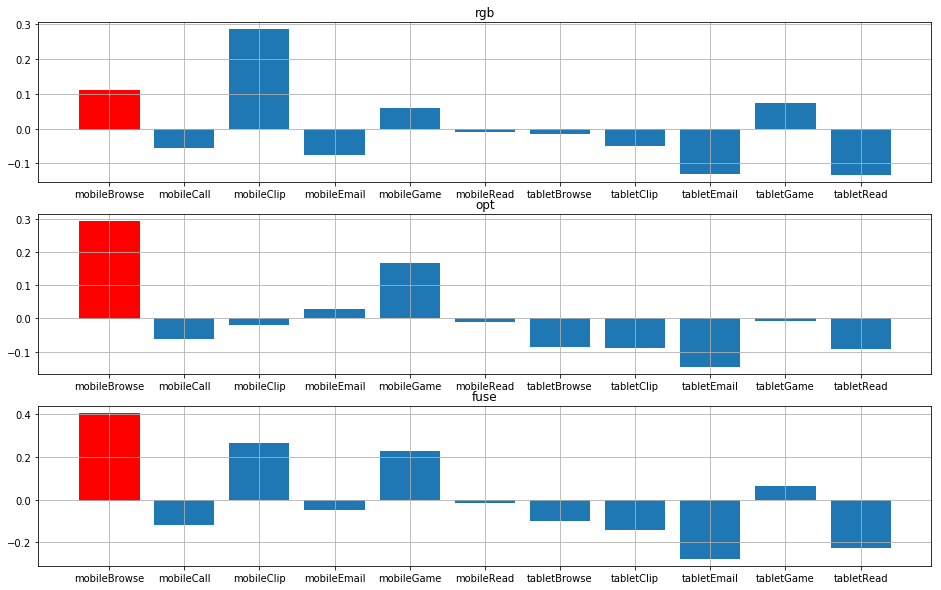

mobileBrowse_g01_c05
False True True


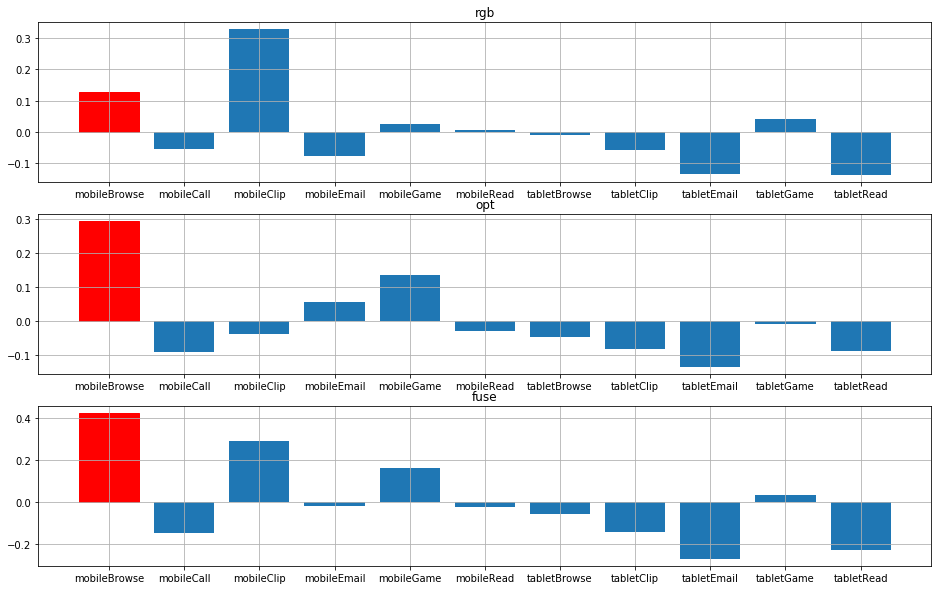

mobileBrowse_g01_c09
False True True


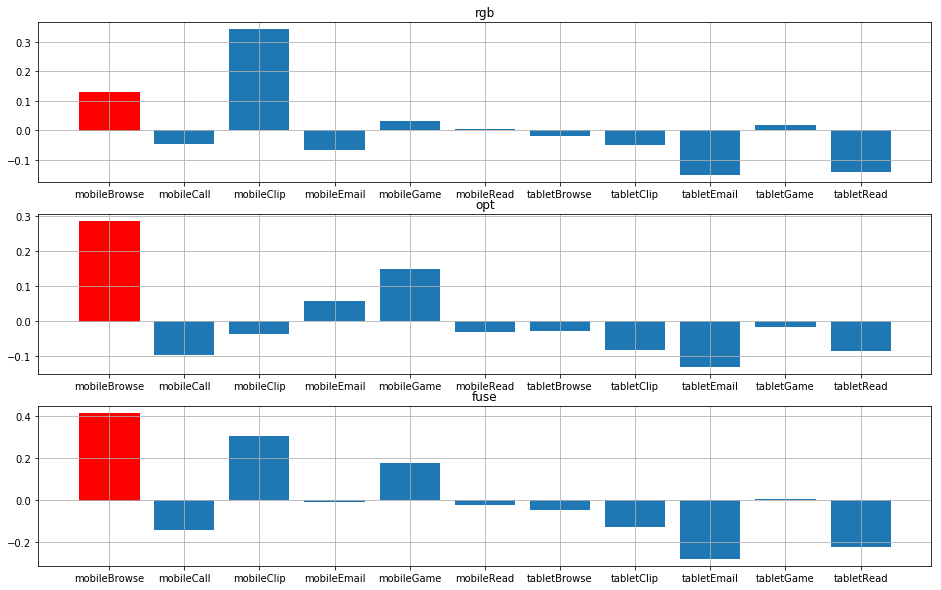

mobileBrowse_g01_c13
False True True


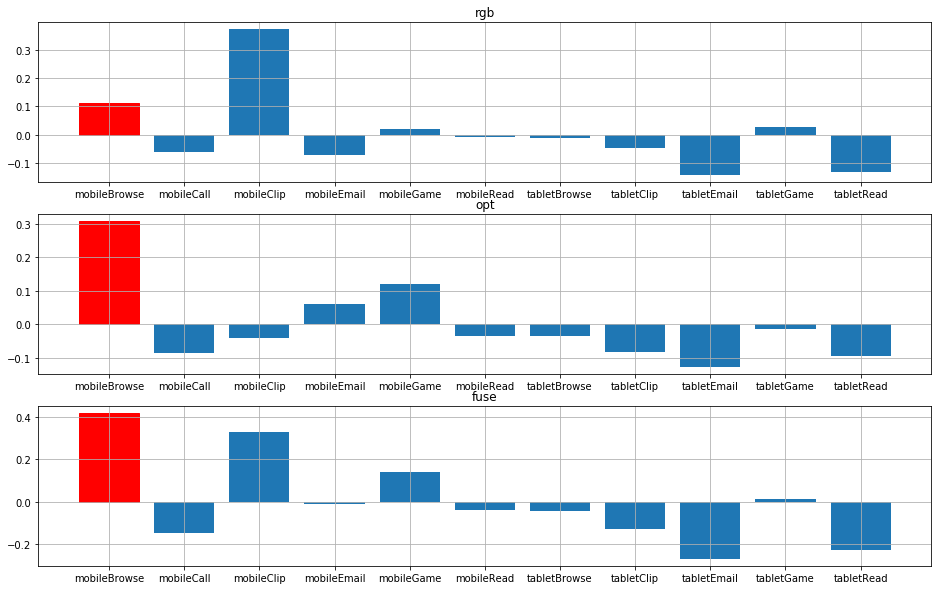

mobileBrowse_g01_c17
False True True


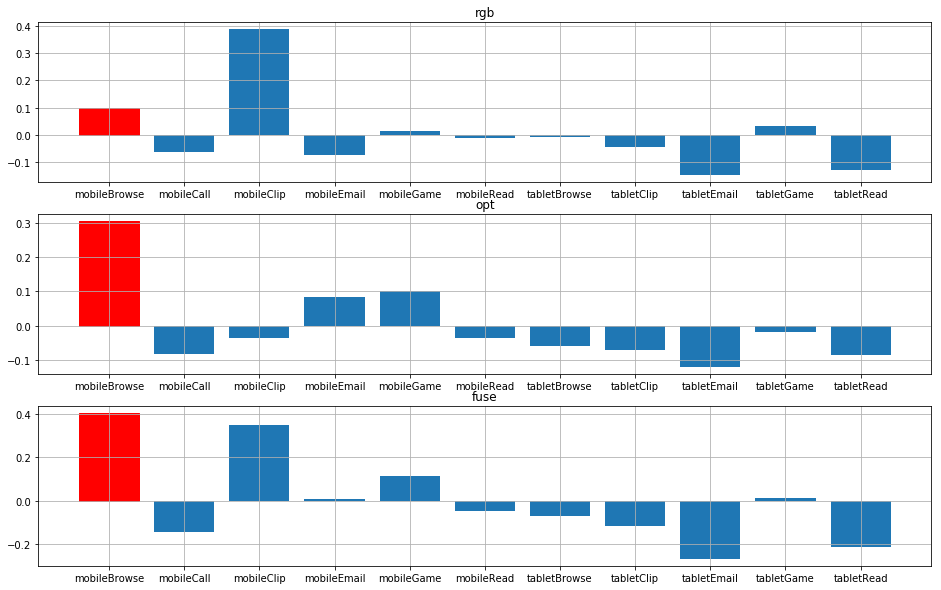

mobileBrowse_g02_c02
False True True


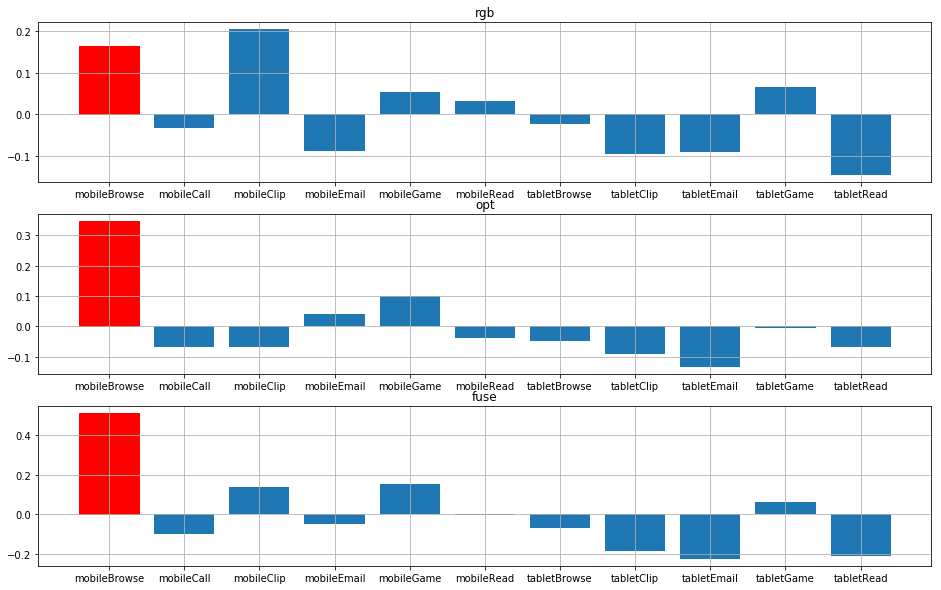

mobileBrowse_g02_c06
False True True


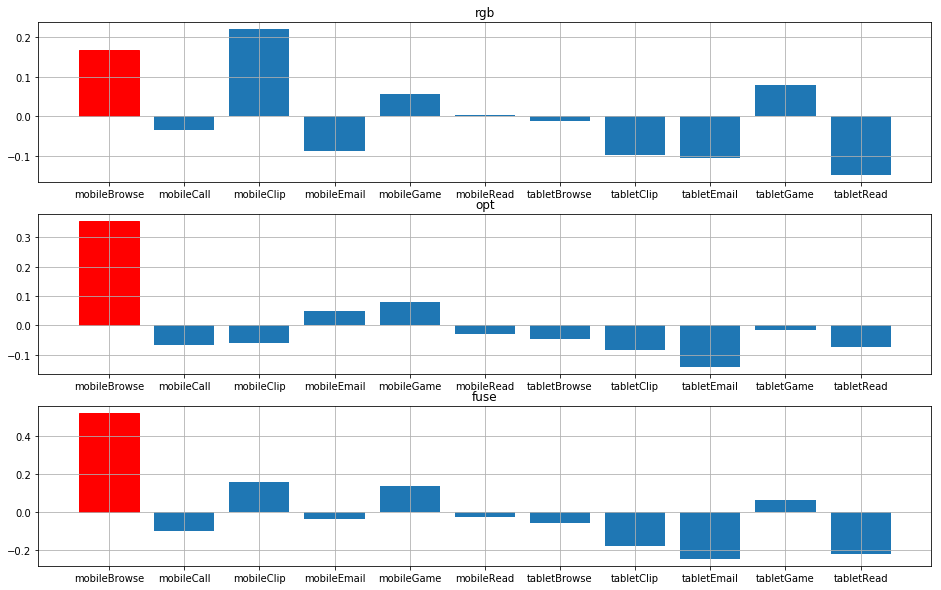

mobileBrowse_g02_c07
False True True


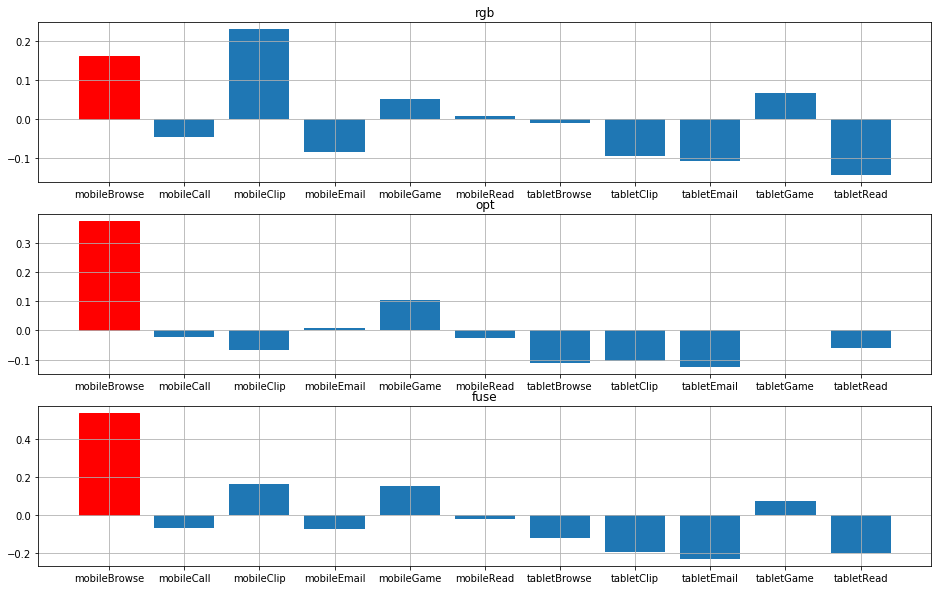

mobileBrowse_g02_c11
False True True


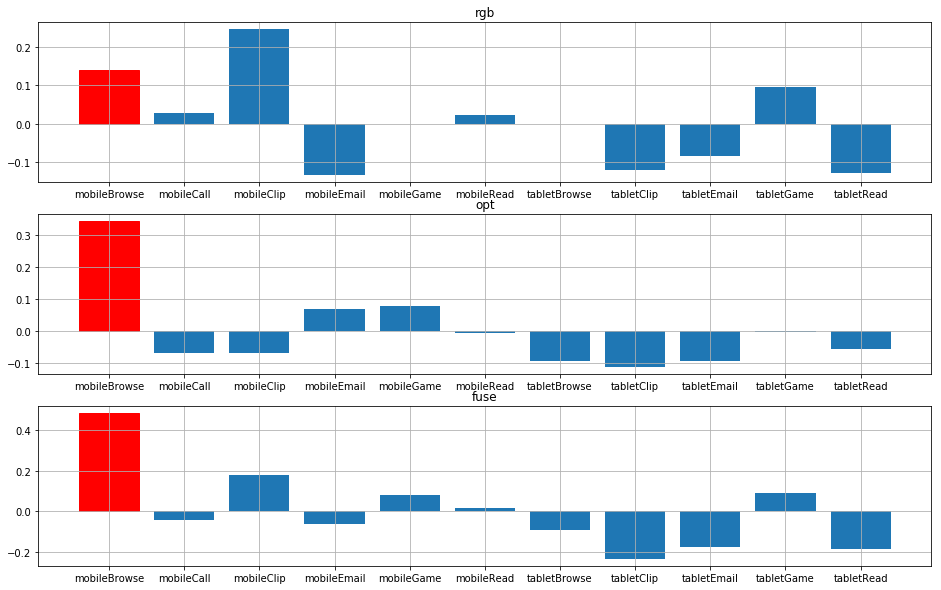

mobileBrowse_g03_c03
True True True


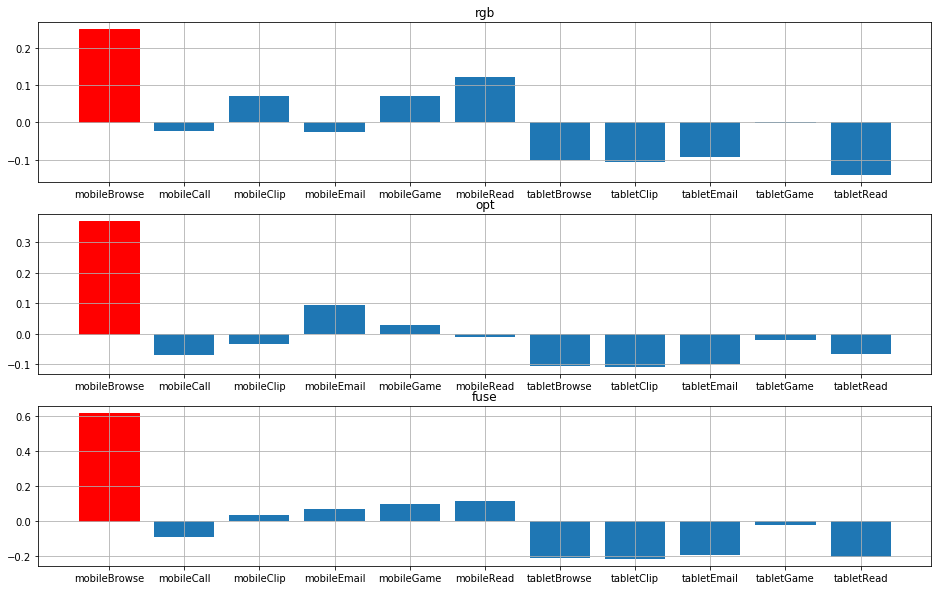

mobileBrowse_g03_c08
True True True


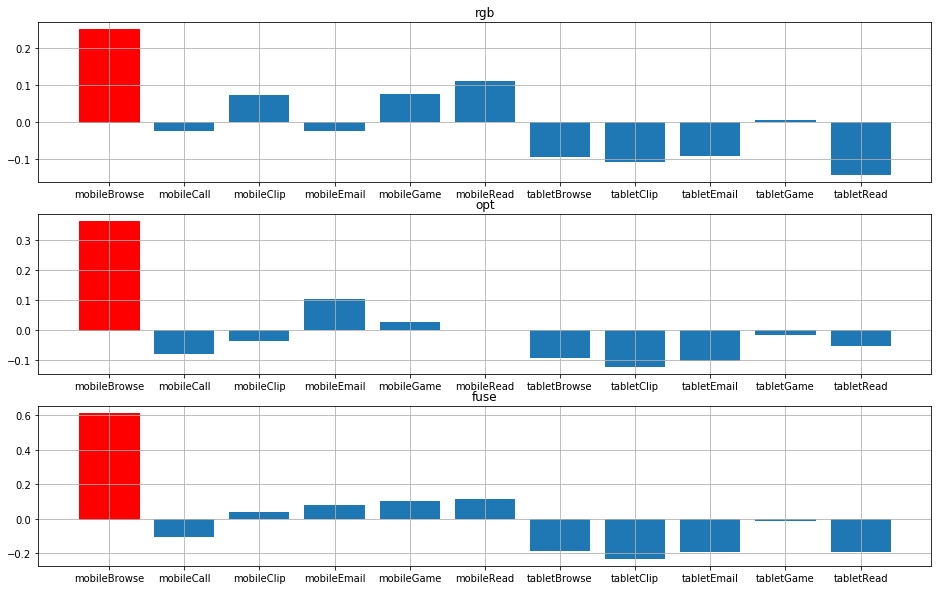

mobileBrowse_g03_c09
True True True


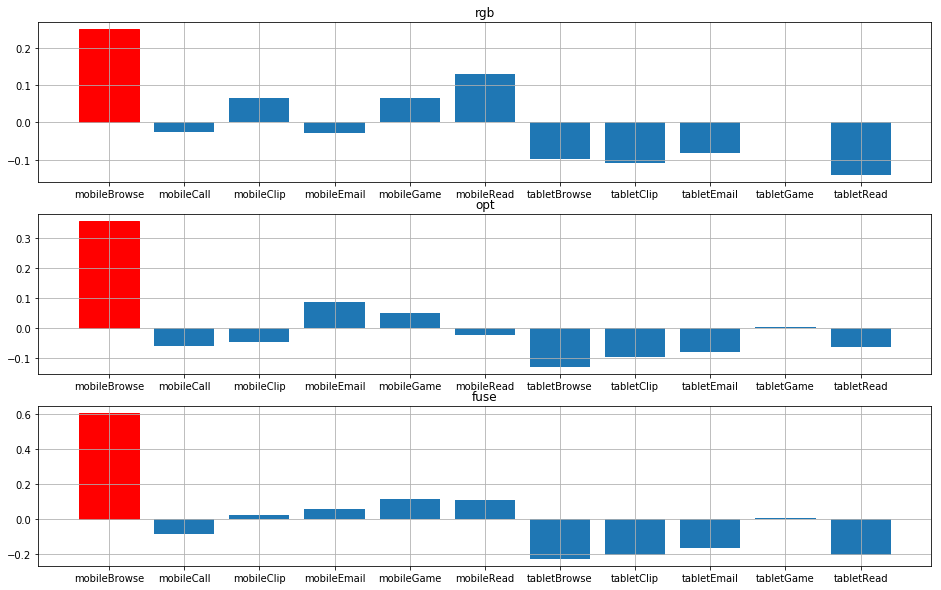

mobileBrowse_g03_c11
True True True


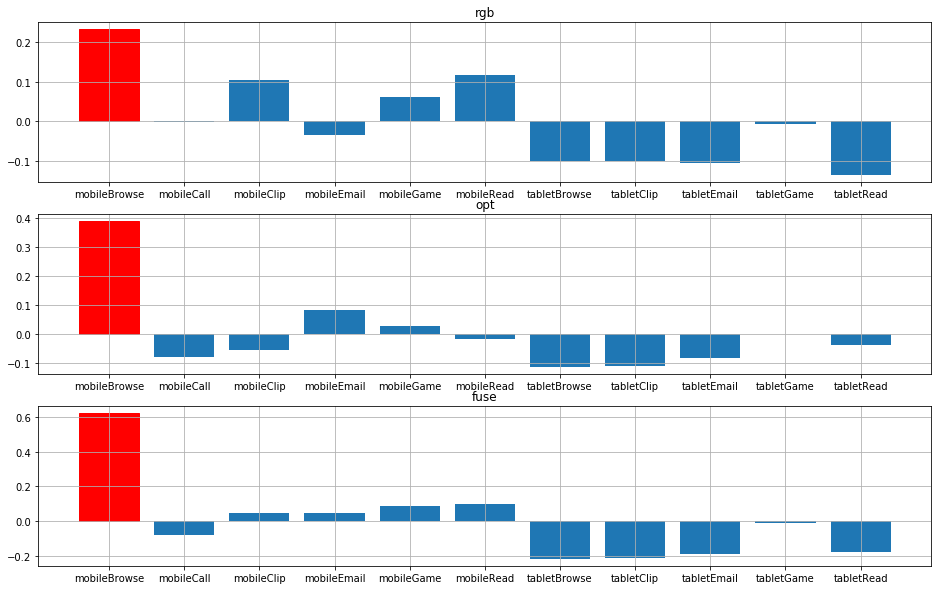

mobileBrowse_g04_c03
True True True


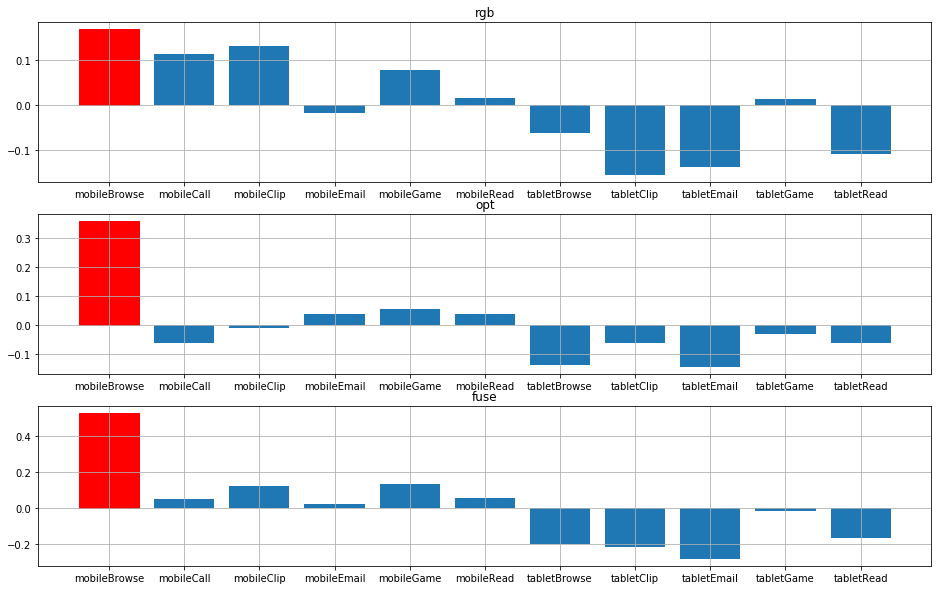

mobileBrowse_g04_c06
False True True


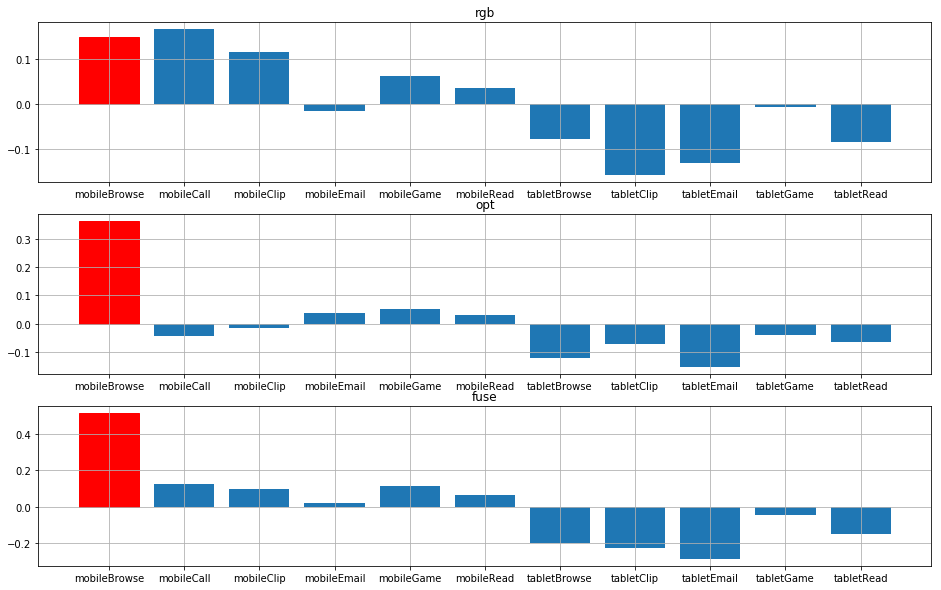

mobileBrowse_g04_c11
True True True


KeyboardInterrupt: ignored

In [22]:
import pickle
import os
import matplotlib.pyplot as plt

rgbPickle = 'record/spatial/evel_spatial_video_preds.pickle'
optPickle = 'record/motion/evel_motion_video_preds.pickle'
classList = 'NDA_list/classInd.txt'

with open(rgbPickle,'rb') as file:
  rgb_dic_frame = pickle.load(file)
file.close()

with open(optPickle,'rb') as file:
  opt_dic_frame = pickle.load(file)
file.close()

classes = []
class_file = open(classList, 'r')
for line in class_file:
  if line[-1] == '\n':
    name = line.split(' ')[1]
    name = name.replace('\n', '')
    classes.append(name)

rgb_correct = 0
opt_correct = 0
fuse_correct = 0
total = 0    
    
    
for name in sorted(rgb_dic_frame.keys()):
  current_class = name.split('_')[0]
  print(name)
  r = rgb_dic_frame[name]
  r = r/sum(abs(r))
#   r = r - min(r)
#   r = r/sum(r)
  o = opt_dic_frame[name]
  o = o/sum(abs(o))
#   o = o - min(o)
#   o = o/sum(o)
  fuse = r+o

  rgb_predict_class = classes[r.tolist().index(max(r))]
  optical_flow_predict_class = classes[o.tolist().index(max(o))]
  fuse_predict_class = classes[fuse.tolist().index(max(fuse))]
  
  f_tf = False
  r_tf = False
  o_tf = False
  if fuse_predict_class == current_class:
    fuse_correct += 1
    f_tf = True
  if rgb_predict_class == current_class:
    rgb_correct += 1
    r_tf = True
  if optical_flow_predict_class == current_class:
    opt_correct += 1
    o_tf = True
  total += 1
  print(r_tf, o_tf, f_tf)
  
  x = range(len(classes))
  
  fig = plt.figure(figsize=(16,10))
  fig.add_subplot(311)

  barList_r = plt.bar(x, r)
  barList_r[classes.index(current_class)].set_color('r')
  plt.xticks(x, classes)
  plt.title('rgb')
  plt.grid()

  fig.add_subplot(312)
  barList_o = plt.bar(x, o)
  barList_o[classes.index(current_class)].set_color('r')
  plt.xticks(x, classes)
  plt.title('opt')
  plt.grid()

  fig.add_subplot(313)
  barList_f = plt.bar(x, fuse)
  barList_f[classes.index(current_class)].set_color('r')
  plt.xticks(x, classes)
  plt.grid()
  plt.title('fuse')
  plt.show()
  
#   ax = plt.subplot(111)
#   ax.bar(x, r, width=0.2, color='b', align='center')
#   ax.bar(x, o, width=0.2, color='g', align='center')
#   ax.bar(x, fuse, width=0.2, color='r', align='center')
  

print('RGB Accuracy = ' + str(rgb_correct/total))
print('Optical Flow Accuracy = ' + str(opt_correct/total))
print('Fuse Accuracy = ' + str(fuse_correct/total))

### Confusion Matrix by Prediction float

{'mobileBrowse': 27, 'mobileCall': 28, 'mobileClip': 27, 'mobileEmail': 37, 'mobileGame': 32, 'mobileRead': 25, 'tabletBrowse': 36, 'tabletClip': 39, 'tabletEmail': 41, 'tabletGame': 32, 'tabletRead': 35}
RGB Accuracy = 0.8774373259052924
Optical Flow Accuracy = 0.9888579387186629
Fuse Accuracy = 0.9888579387186629


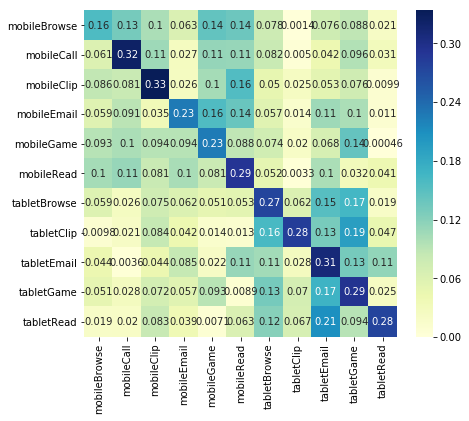

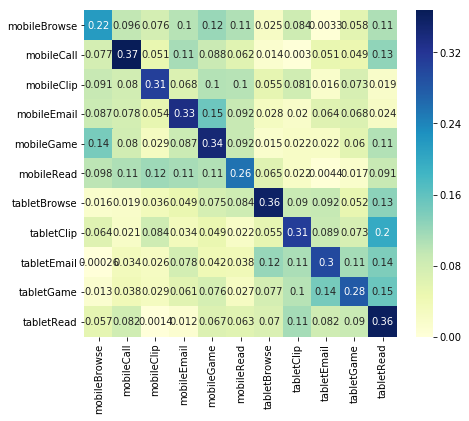

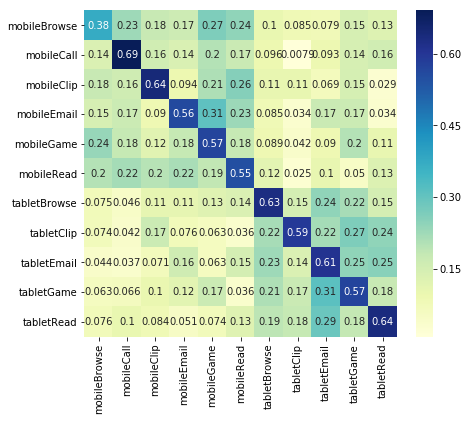

In [0]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd

rgbPickle = 'record/spatial/evel_spatial_video_preds.pickle'
optPickle = 'record/motion/evel_motion_video_preds.pickle'
classList = 'NDA_list/classInd.txt'

with open(rgbPickle,'rb') as file:
  rgb_dic_frame = pickle.load(file)
file.close()

with open(optPickle,'rb') as file:
  opt_dic_frame = pickle.load(file)
file.close()

classes = []
class_ind = {}
class_file = open(classList, 'r')
for line in class_file:
  if line[-1] == '\n':
    ind = int(line.split(' ')[0])
    name = line.split(' ')[1]
    name = name.replace('\n', '')
    classes.append(name)
    class_ind[name] = ind - 1

rgb_correct = 0
opt_correct = 0
fuse_correct = 0
total = 0    

class_num = len(classes)

R_confusion = np.empty((class_num, class_num))
O_confusion = np.empty((class_num, class_num))
F_confusion = np.empty((class_num, class_num))

R_confusion.fill(0)
O_confusion.fill(0)
F_confusion.fill(0)

class_appear = {}

for name in sorted(rgb_dic_frame.keys()):
  current_class = name.split('_')[0]
  if current_class not in class_appear:
    class_appear[current_class] = 1
  else:
    class_appear[current_class] += 1
#   print(name)
  r = rgb_dic_frame[name]
#   r = r/sum(abs(r))
  r = r - min(r)
  r = r/sum(r)
  o = opt_dic_frame[name]
#   o = o/sum(abs(o))
  o = o - min(o)
  o = o/sum(o)
  fuse = r+o
  
  R_confusion[class_ind[current_class]] += r
  O_confusion[class_ind[current_class]] += o
  F_confusion[class_ind[current_class]] += fuse
  
  rgb_predict_class = classes[r.tolist().index(max(r))]
  optical_flow_predict_class = classes[o.tolist().index(max(o))]
  fuse_predict_class = classes[fuse.tolist().index(max(fuse))]
  
  f_tf = False
  r_tf = False
  o_tf = False
  if fuse_predict_class == current_class:
    fuse_correct += 1
    f_tf = True
  if rgb_predict_class == current_class:
    rgb_correct += 1
    r_tf = True
  if optical_flow_predict_class == current_class:
    opt_correct += 1
    o_tf = True
  total += 1
#   print(r_tf, o_tf, f_tf)  
print(class_appear)
for name in classes:
  R_confusion[class_ind[name]] /= class_appear[name]
  O_confusion[class_ind[name]] /= class_appear[name]
  F_confusion[class_ind[name]] /= class_appear[name]

R_df_cm = pd.DataFrame(R_confusion, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (7,6))
sn.heatmap(R_df_cm, annot=True, cmap="YlGnBu")

O_df_cm = pd.DataFrame(O_confusion, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (7,6))
sn.heatmap(O_df_cm, annot=True, cmap="YlGnBu")


F_df_cm = pd.DataFrame(F_confusion, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (7,6))
sn.heatmap(F_df_cm, annot=True, cmap="YlGnBu")


print('RGB Accuracy = ' + str(rgb_correct/total))
print('Optical Flow Accuracy = ' + str(opt_correct/total))
print('Fuse Accuracy = ' + str(fuse_correct/total))

### Confusion Matrix by Accuracy

{'mobileBrowse': 46, 'mobileCall': 38, 'mobileClip': 39, 'mobileEmail': 48, 'mobileGame': 44, 'mobileRead': 42, 'tabletBrowse': 46, 'tabletClip': 43, 'tabletEmail': 40, 'tabletGame': 46, 'tabletRead': 41}
total:  473


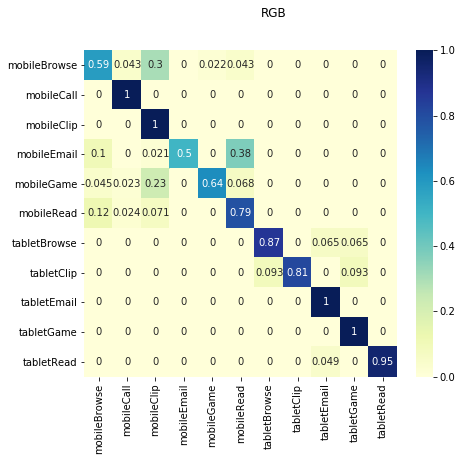

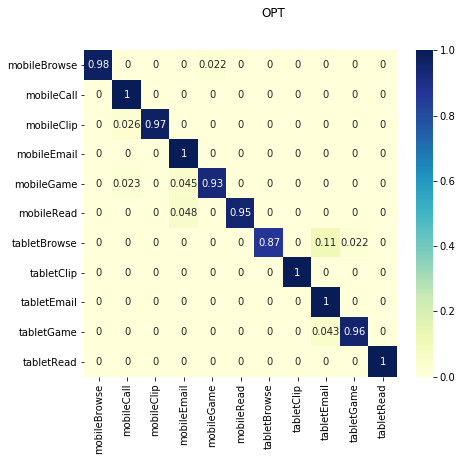

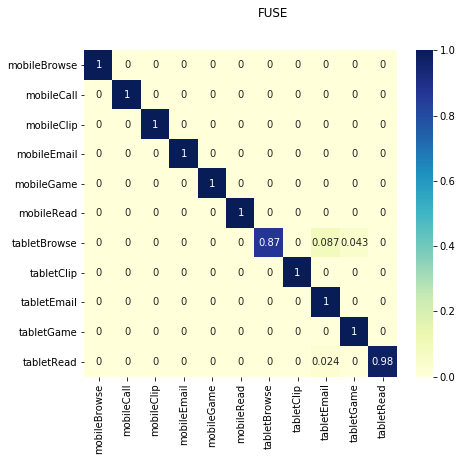

RGB Accuracy = 0.8224101479915433
Optical Flow Accuracy = 0.9682875264270613
Fuse Accuracy = 0.985200845665962


In [21]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd

rgbPickle = 'record/spatial/evel_spatial_video_preds.pickle'
optPickle = 'record/motion/evel_motion_video_preds.pickle'
classList = 'NDA_list/classInd.txt'

with open(rgbPickle,'rb') as file:
  rgb_dic_frame = pickle.load(file)
file.close()

with open(optPickle,'rb') as file:
  opt_dic_frame = pickle.load(file)
file.close()

classes = []
class_ind = {}
class_file = open(classList, 'r')
for line in class_file:
  if line[-1] == '\n':
    ind = int(line.split(' ')[0])
    name = line.split(' ')[1]
    name = name.replace('\n', '')
    classes.append(name)
    class_ind[name] = ind - 1

rgb_correct = 0
opt_correct = 0
fuse_correct = 0
total = 0    

class_num = len(classes)

R_confusion = np.empty((class_num, class_num))
O_confusion = np.empty((class_num, class_num))
F_confusion = np.empty((class_num, class_num))

R_confusion.fill(0)
O_confusion.fill(0)
F_confusion.fill(0)

class_appear = {}

for name in sorted(rgb_dic_frame.keys()):
  current_class = name.split('_')[0]
  if current_class not in class_appear:
    class_appear[current_class] = 1
  else:
    class_appear[current_class] += 1
#   print(name)
  r = rgb_dic_frame[name]
  r = r/sum(abs(r))
#   r = r - min(r)
#   r = r/sum(r)
  o = opt_dic_frame[name]
  o = o/sum(abs(o))
#   o = o - min(o)
#   o = o/sum(o)
  fuse = r+o
  
  
  rgb_predict_class = classes[r.tolist().index(max(r))]
  optical_flow_predict_class = classes[o.tolist().index(max(o))]
  fuse_predict_class = classes[fuse.tolist().index(max(fuse))]
  
  R_confusion[class_ind[current_class]][class_ind[rgb_predict_class]] += 1
  O_confusion[class_ind[current_class]][class_ind[optical_flow_predict_class]] += 1
  F_confusion[class_ind[current_class]][class_ind[fuse_predict_class]] += 1
  
  f_tf = False
  r_tf = False
  o_tf = False
  if fuse_predict_class == current_class:
    fuse_correct += 1
    f_tf = True
  if rgb_predict_class == current_class:
    rgb_correct += 1
    r_tf = True
  if optical_flow_predict_class == current_class:
    opt_correct += 1
    o_tf = True
  total += 1
#   print(r_tf, o_tf, f_tf)  
print(class_appear)
print('total: ', total)
for name in classes:
  R_confusion[class_ind[name]] /= class_appear[name]
  O_confusion[class_ind[name]] /= class_appear[name]
  F_confusion[class_ind[name]] /= class_appear[name]

R_df_cm = pd.DataFrame(R_confusion, index = [i for i in classes],
                  columns = [i for i in classes])
fig = plt.figure(figsize = (7,6))
fig.suptitle('RGB')
sn.heatmap(R_df_cm, annot=True, cmap="YlGnBu")

O_df_cm = pd.DataFrame(O_confusion, index = [i for i in classes],
                  columns = [i for i in classes])
fig1 = plt.figure(figsize = (7,6))
fig1.suptitle('OPT')
sn.heatmap(O_df_cm, annot=True, cmap="YlGnBu")


F_df_cm = pd.DataFrame(F_confusion, index = [i for i in classes],
                  columns = [i for i in classes])
fig2 = plt.figure(figsize = (7,6))
fig2.suptitle('FUSE')
sn.heatmap(F_df_cm, annot=True, cmap="YlGnBu")

plt.show()

print('RGB Accuracy = ' + str(rgb_correct/total))
print('Optical Flow Accuracy = ' + str(opt_correct/total))
print('Fuse Accuracy = ' + str(fuse_correct/total))

# loop infernece


In [0]:
!python get_class.py

for i in range(3):
  print()
  print('inference no.' + str(i) + '!!!!')
  print()
  !python get_list_70_20_10.py --train 64 --test 16 --inference 20
  !python get_frame_count_pickle.py

  
  !python spatial_cnn.py  --lr 0.005 --epochs 20 --jpeg jpeg_1080/ --NDAlist NDA_list/ \
  --batch-size 32 --net-size 34 --numClass 4

  !python motion_cnn.py  --lr 0.005 --epochs 20 --opt flowNet_1080/ --NDAlist NDA_list/ \
  --batch-size 32 --net-size 50 --numClass 4 
  
  
  !python spatial_cnn.py --batch-size 32 --epoch 1 --jpeg jpeg_1080/ \
  --NDAlist n_NDA_list/ --resume record/spatial/model_best.pth.tar \
  --net-size 34 --evaluate --numClass 4
  
  !python motion_cnn.py --batch-size 32 --epoch 1 --opt flowNet_1080/ \
  --NDAlist n_NDA_list/ --resume record/motion/model_best.pth.tar \
  --net-size 50 --evaluate --numClass 4

  !python predict_pickle_reader_for_loop.py

Namespace(jpg_path='jpeg_1080')
1 tabletBrowse

2 tabletClip

3 tabletGame

4 tabletRead


inference no.0!!!!

Namespace(inference=10, jpg_path='jpeg_1080', test=20, train=70)
['tabletClip_g01_c07.mp4', 'tabletClip_g01_c02.mp4', 'tabletClip_g04_c19.mp4', 'tabletBrowse_g02_c17.mp4', 'tabletBrowse_g04_c17.mp4', 'tabletClip_g04_c13.mp4', 'tabletClip_g04_c08.mp4', 'tabletRead_g02_c17.mp4', 'tabletRead_g03_c07.mp4', 'tabletBrowse_g03_c04.mp4', 'tabletClip_g02_c07.mp4', 'tabletGame_g04_c11.mp4', 'tabletGame_g04_c14.mp4', 'tabletRead_g02_c16.mp4', 'tabletGame_g03_c07.mp4', 'tabletGame_g04_c12.mp4', 'tabletClip_g03_c18.mp4', 'tabletBrowse_g04_c15.mp4', 'tabletRead_g01_c11.mp4', 'tabletBrowse_g01_c13.mp4', 'tabletGame_g02_c12.mp4', 'tabletBrowse_g02_c10.mp4', 'tabletGame_g02_c06.mp4', 'tabletRead_g02_c07.mp4', 'tabletClip_g03_c19.mp4', 'tabletRead_g04_c17.mp4', 'tabletBrowse_g03_c17.mp4', 'tabletBrowse_g01_c16.mp4', 'tabletGame_g01_c08.mp4', 'tabletClip_g04_c18.mp4', 'tabletBrowse_g04_c04.mp4',

KeyboardInterrupt: ignored